In [254]:
from neural_punctuator.utils.data import get_config_from_yaml
from neural_punctuator.models.BertPunctuator import BertPunctuator
from neural_punctuator.preprocessors.BertPreprocessor import BertPreprocessor

import logging
import sys
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from neural_punctuator.base.BaseTrainer import BaseTrainer
from neural_punctuator.data.dataloader import BertDataset, collate, get_data_loaders, get_datasets
from neural_punctuator.models.BertPunctuator import BertPunctuator
from torch.optim import AdamW  # TODO
from torch import nn
from torch.utils.tensorboard import SummaryWriter

from neural_punctuator.utils.data import get_target_weights
from neural_punctuator.utils.io import save, load
from neural_punctuator.utils.metrics import get_total_grad_norm, get_eval_metrics
from neural_punctuator.utils.tensorboard import print_metrics
from neural_punctuator.utils.scheduler import LinearScheduler
import numpy as np
import pickle

from torch.utils.data import Dataset, DataLoader

torch.manual_seed(69)
np.random.seed(69)

In [2]:
config = get_config_from_yaml('neural_punctuator/configs/config-unfreeze.yaml')

In [15]:
config.trainer.load_model = "albert-unfreeze-epoch-3.pth"

In [16]:
config.trainer.load_model 

'albert-unfreeze-epoch-3.pth'

In [17]:
preprocessor = BertPreprocessor(config)

Using cache found in C:\Users\gbenc/.cache\torch\hub\huggingface_pytorch-transformers_master


In [18]:
model = BertPunctuator(config)

Using cache found in C:\Users\gbenc/.cache\torch\hub\huggingface_pytorch-transformers_master


In [19]:
device = torch.device('cuda:0')
torch.cuda.set_device(device)

In [20]:
model.to(device)

BertPunctuator(
  (bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
     

In [22]:
load(model, None, config)

In [60]:
config.model.predict_step = 1 

In [61]:
class BertDataset(Dataset):
    def __init__(self, prefix, config, is_train=False):

        self.config = config
        self.is_train = is_train

        with open(config.data.data_path + prefix + "_data.pkl", 'rb') as f:
            texts, targets = pickle.load(f)
            self.encoded_texts = [word for t in texts for word in t]
            self.targets = [t for ts in targets for t in ts]

    def __getitem__(self, idx):
        if self.is_train:
            shift = np.random.randint(self.config.trainer.seq_shift) - self.config.trainer.seq_shift // 2
        else:
            shift = 0

        start_idx = idx * config.model.predict_step + shift
        start_idx = max(0, start_idx)
        end_idx = start_idx + self.config.model.seq_len
        return torch.LongTensor(self.encoded_texts[start_idx: end_idx]),\
               torch.LongTensor(self.targets[start_idx: end_idx])

    def __len__(self):
        return (len(self.encoded_texts)-self.config.model.seq_len)//config.model.predict_step + 1


In [62]:
valid_dataset = BertDataset("valid", config)

In [63]:
len(valid_dataset)

414412

In [64]:
valid_dataset[0][0][:100], valid_dataset[1][0][:100]

(tensor([    2, 10975,    51,   204,    25,   831,  9713,  3602,    31,    57,
            21,  1120,    19,   479,    30,    63,    21,  1498,  2141,    20,
         15026,  1374,    76,    31,    23,  1991,    71,    31,    23,  5043,
            20,   544,    17, 15698,    17,  2895,    17,  9448,    27,    21,
           284,  3464,    17,    31,    23,    80,   699,    35,    14,  1662,
          3464,    16,  1374,    17,  3007,    30,    14,  1374,    30,    46,
           140,    55,    17,    30,    46,   142,  1006,    17,    30,    46,
            80,    19,    14,  4411,    31,    23,  2078,   427,  2069,   923,
            17,  1191,    17,    80,    27,    14,  2012,  3464,    14,  3464,
            16,    40,  2330,  2090,    54,    21, 16380,  3997,    54,    21]),
 tensor([10975,    51,   204,    25,   831,  9713,  3602,    31,    57,    21,
          1120,    19,   479,    30,    63,    21,  1498,  2141,    20, 15026,
          1374,    76,    31,    23,  1991,    71,

In [65]:
config.predict.batch_size = 128
valid_loader = DataLoader(valid_dataset, batch_size=config.predict.batch_size, collate_fn=collate)

In [66]:
model.eval()
all_valid_preds = []

for data in tqdm(valid_loader):
    text, targets = data
    with torch.no_grad():
        preds = model(text.to(device))

    all_valid_preds.append(preds.detach().cpu().numpy())

  4%|███▏                                                                         | 133/3238 [09:01<3:30:42,  4.07s/it]


KeyboardInterrupt: 

In [124]:
# with open("all_valid_preds.pkl", "wb") as f:
#     pickle.dump(all_valid_preds, f)
with open("all_valid_preds.pkl", "rb") as f:
    all_valid_preds = pickle.load(f)

In [125]:
all_valid_target = valid_dataset.targets
len(all_valid_target)

414923

In [126]:
len(all_valid_preds), all_valid_preds[0].shape

(133, (128, 512, 4))

In [127]:
all_valid_preds = np.concatenate(all_valid_preds)
all_valid_preds.shape

(17024, 512, 4)

In [128]:
config.model.seq_len, config.model.predict_step

(512, 1)

In [129]:
pred_num = config.model.seq_len // config.model.predict_step
pred_num

512

In [130]:
all_targets = []
all_preds = []

for i in range(0, all_valid_preds.shape[0]//pred_num):
    targets = all_valid_target[i*config.model.seq_len: (i+1)*config.model.seq_len]
    
    preds = all_valid_preds[i*pred_num]
    
    all_targets.append(targets)
    all_preds.append(preds)

In [131]:
targets = np.concatenate(all_targets)
preds = np.concatenate(all_preds)

targets.shape, preds.shape

((16896,), (16896, 4))

(array([14843.,     0.,     0.,   840.,     0.,     0.,    16.,     0.,
            0.,  1197.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

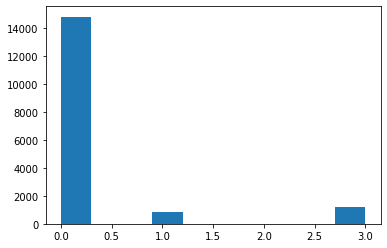

In [132]:
import matplotlib.pyplot as plt

plt.hist(preds.argmax(-1))

              precision    recall  f1-score   support

           0      0.989     0.983     0.986     14933
           1      0.867     0.776     0.819       938
           2      0.938     0.517     0.667        29
           3      0.677     0.813     0.739       996

    accuracy                          0.961     16896
   macro avg      0.867     0.772     0.803     16896
weighted avg      0.964     0.961     0.962     16896

2020-10-29 17:02:16,189 INFO      Macro precision is: 0.8674860400808327
2020-10-29 17:02:16,195 INFO      Macro recall is 0.7724346044152742
2020-10-29 17:02:16,203 INFO      Macro f-score is 0.8025936448990191
2020-10-29 17:02:16,331 INFO      Plotting confusion matrix without normalization


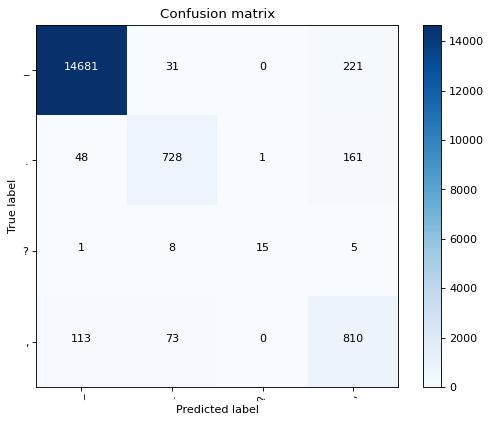

In [133]:
metrics = get_eval_metrics(targets, preds, config)

In [134]:
all_valid_preds.shape, len(all_valid_target), pred_num

((17024, 512, 4), 414923, 512)

In [135]:
pred_count = all_valid_preds.shape[0]
pred_count

17024

In [280]:
pred_num = 64
relevant_preds = all_valid_preds[::pred_num]
relevant_preds.shape

(266, 512, 4)

In [281]:
def combine(pred_num):

    relevant_preds = all_valid_preds[::pred_num]

    ps = []

    for i in range(relevant_preds.shape[0]):#+512//pred_num-1):
    #     ps.append(relevant_preds[i, :pred_num])


        start_idx = max(0, i-512//pred_num+1)
        end_idx = min(relevant_preds.shape[0], i+1)

        p = []
        for j, k in enumerate(range(start_idx, end_idx)):
            j = end_idx - start_idx - j - 1
    #         print(k, j, relevant_preds[k][j*pred_num:(j+1)*pred_num].mean())
            p.append(relevant_preds[k][j*pred_num:(j+1)*pred_num])
    #     print()
        p = np.stack(p)
        
        if p.shape[0] > 2:
            p = p[1:-1, :, :]
            
        ps.append(np.log(np.exp(p).mean(0)))

    ps = np.concatenate(ps)
    
    return ps
ps = combine(pred_num)

In [282]:
ps.shape

(17024, 4)

In [283]:
type(all_valid_target)

list

              precision    recall  f1-score   support

           0      0.991     0.985     0.988     15050
           1      0.876     0.801     0.837       945
           2      0.944     0.586     0.723        29
           3      0.689     0.821     0.749      1000

    accuracy                          0.964     17024
   macro avg      0.875     0.798     0.824     17024
weighted avg      0.967     0.964     0.965     17024

2020-10-29 20:00:30,209 INFO      Macro precision is: 0.875243983127715
2020-10-29 20:00:30,215 INFO      Macro recall is 0.7981958425087936
2020-10-29 20:00:30,220 INFO      Macro f-score is 0.8243818231803225
2020-10-29 20:00:30,343 INFO      Plotting confusion matrix without normalization


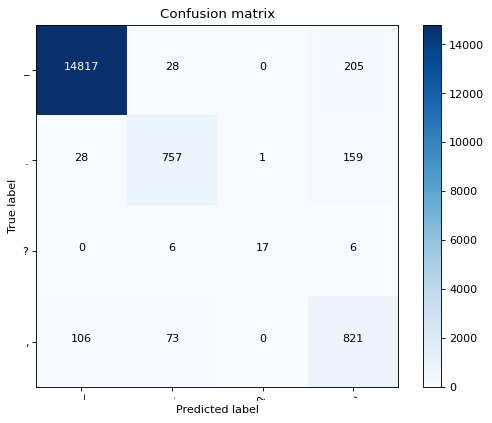

In [284]:
metrics = get_eval_metrics(np.array(all_valid_target[:ps.shape[0]]), ps, config)

              precision    recall  f1-score   support

           0      0.991     0.984     0.988     15050
           1      0.874     0.797     0.833       945
           2      0.938     0.517     0.667        29
           3      0.689     0.821     0.749      1000

    accuracy                          0.964     17024
   macro avg      0.873     0.780     0.809     17024
weighted avg      0.966     0.964     0.964     17024

2020-10-29 20:00:57,891 INFO      Macro precision is: 0.8726449932830238
2020-10-29 20:00:57,896 INFO      Macro recall is 0.7798796508445667
2020-10-29 20:00:57,902 INFO      Macro f-score is 0.8091953695647445
2020-10-29 20:00:58,033 INFO      Plotting confusion matrix without normalization


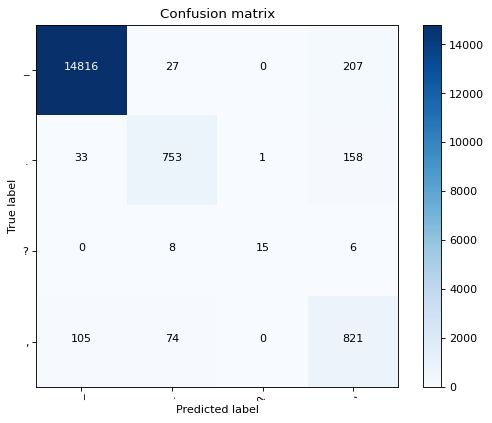

1 0.8091953695647445
              precision    recall  f1-score   support

           0      0.991     0.984     0.988     15050
           1      0.874     0.797     0.833       945
           2      0.938     0.517     0.667        29
           3      0.689     0.822     0.750      1000

    accuracy                          0.964     17024
   macro avg      0.873     0.780     0.809     17024
weighted avg      0.967     0.964     0.965     17024

2020-10-29 20:01:04,168 INFO      Macro precision is: 0.8727267805142432
2020-10-29 20:01:04,174 INFO      Macro recall is 0.7801296508445666
2020-10-29 20:01:04,180 INFO      Macro f-score is 0.8093462016293769
2020-10-29 20:01:04,487 INFO      Plotting confusion matrix without normalization


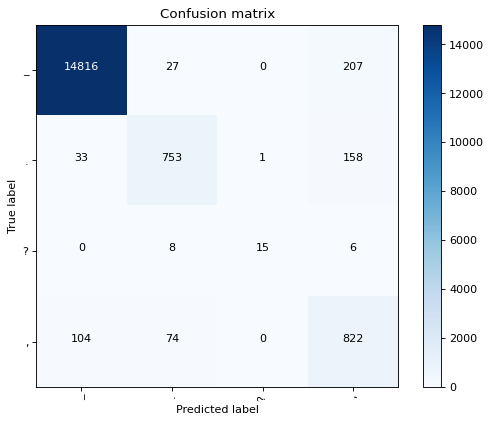

2 0.8093462016293769
              precision    recall  f1-score   support

           0      0.991     0.984     0.988     15050
           1      0.874     0.799     0.835       945
           2      0.938     0.517     0.667        29
           3      0.690     0.822     0.750      1000

    accuracy                          0.964     17024
   macro avg      0.873     0.781     0.810     17024
weighted avg      0.967     0.964     0.965     17024

2020-10-29 20:01:06,346 INFO      Macro precision is: 0.8730892184871836
2020-10-29 20:01:06,351 INFO      Macro recall is 0.7806587513736671
2020-10-29 20:01:06,357 INFO      Macro f-score is 0.8098397145795014
2020-10-29 20:01:06,490 INFO      Plotting confusion matrix without normalization


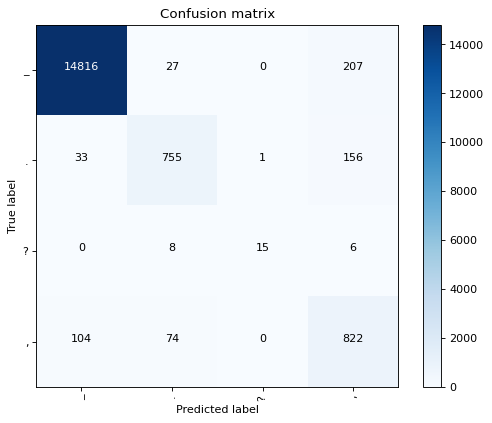

4 0.8098397145795014
              precision    recall  f1-score   support

           0      0.991     0.984     0.988     15050
           1      0.875     0.801     0.836       945
           2      0.941     0.552     0.696        29
           3      0.690     0.822     0.750      1000

    accuracy                          0.964     17024
   macro avg      0.874     0.790     0.818     17024
weighted avg      0.967     0.964     0.965     17024

2020-10-29 20:01:07,279 INFO      Macro precision is: 0.8743502300409873
2020-10-29 20:01:07,284 INFO      Macro recall is 0.7897919302622591
2020-10-29 20:01:07,290 INFO      Macro f-score is 0.8175230793250974
2020-10-29 20:01:07,413 INFO      Plotting confusion matrix without normalization


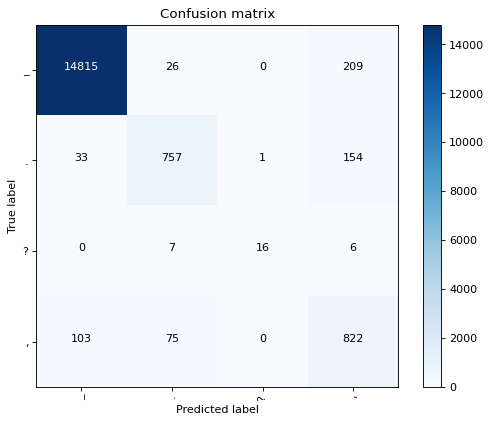

8 0.8175230793250974
              precision    recall  f1-score   support

           0      0.991     0.984     0.988     15050
           1      0.874     0.799     0.835       945
           2      0.941     0.552     0.696        29
           3      0.690     0.822     0.750      1000

    accuracy                          0.964     17024
   macro avg      0.874     0.789     0.817     17024
weighted avg      0.967     0.964     0.965     17024

2020-10-29 20:01:07,873 INFO      Macro precision is: 0.8740249031145617
2020-10-29 20:01:07,879 INFO      Macro recall is 0.7892794410288395
2020-10-29 20:01:07,885 INFO      Macro f-score is 0.8170943211305286
2020-10-29 20:01:08,013 INFO      Plotting confusion matrix without normalization


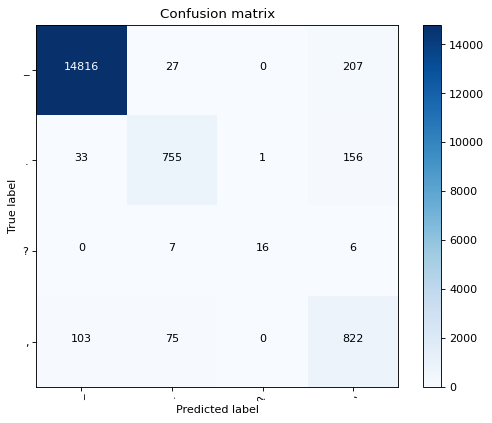

16 0.8170943211305286
              precision    recall  f1-score   support

           0      0.991     0.985     0.988     15050
           1      0.874     0.803     0.837       945
           2      0.944     0.586     0.723        29
           3      0.689     0.813     0.746      1000

    accuracy                          0.964     17024
   macro avg      0.875     0.797     0.824     17024
weighted avg      0.967     0.964     0.965     17024

2020-10-29 20:01:08,378 INFO      Macro precision is: 0.8746564065237543
2020-10-29 20:01:08,384 INFO      Macro recall is 0.7967747769249374
2020-10-29 20:01:08,389 INFO      Macro f-score is 0.8235746710955629
2020-10-29 20:01:08,512 INFO      Plotting confusion matrix without normalization


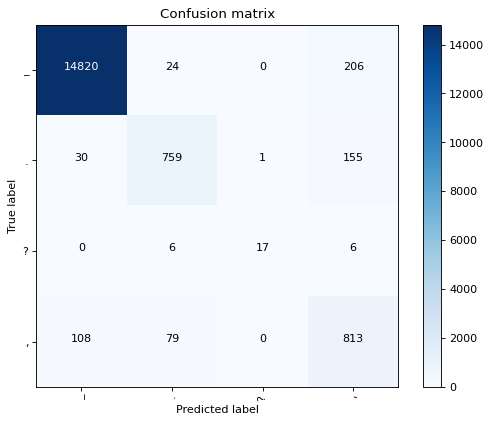

32 0.8235746710955629
              precision    recall  f1-score   support

           0      0.991     0.985     0.988     15050
           1      0.876     0.801     0.837       945
           2      0.944     0.586     0.723        29
           3      0.689     0.821     0.749      1000

    accuracy                          0.964     17024
   macro avg      0.875     0.798     0.824     17024
weighted avg      0.967     0.964     0.965     17024

2020-10-29 20:01:08,846 INFO      Macro precision is: 0.875243983127715
2020-10-29 20:01:08,851 INFO      Macro recall is 0.7981958425087936
2020-10-29 20:01:08,857 INFO      Macro f-score is 0.8243818231803225
2020-10-29 20:01:08,980 INFO      Plotting confusion matrix without normalization


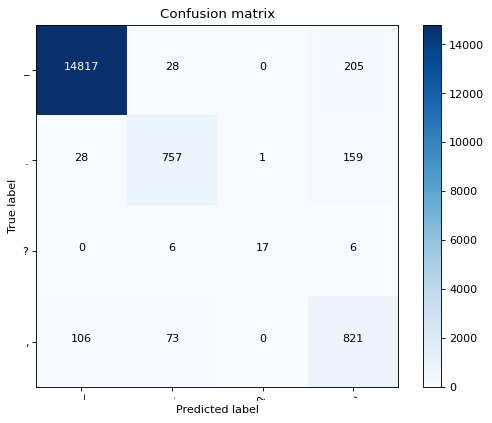

64 0.8243818231803225
              precision    recall  f1-score   support

           0      0.991     0.984     0.987     15050
           1      0.865     0.810     0.837       945
           2      0.941     0.552     0.696        29
           3      0.693     0.812     0.748      1000

    accuracy                          0.964     17024
   macro avg      0.873     0.789     0.817     17024
weighted avg      0.966     0.964     0.964     17024

2020-10-29 20:01:09,299 INFO      Macro precision is: 0.8725242033726194
2020-10-29 20:01:09,304 INFO      Macro recall is 0.789358498491618
2020-10-29 20:01:09,310 INFO      Macro f-score is 0.8168266475832867
2020-10-29 20:01:09,433 INFO      Plotting confusion matrix without normalization


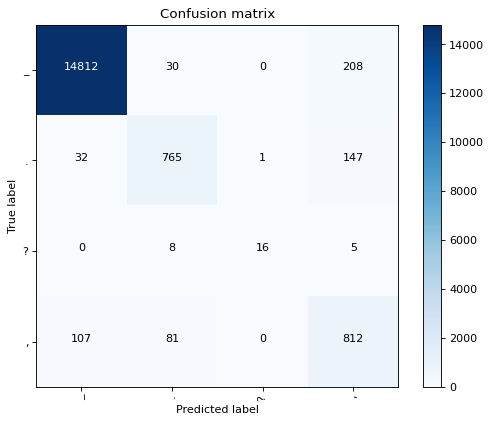

128 0.8168266475832867
              precision    recall  f1-score   support

           0      0.990     0.984     0.987     15160
           1      0.873     0.782     0.825       954
           2      0.941     0.552     0.696        29
           3      0.684     0.818     0.745      1009

    accuracy                          0.963     17152
   macro avg      0.872     0.784     0.813     17152
weighted avg      0.965     0.963     0.963     17152

2020-10-29 20:01:09,771 INFO      Macro precision is: 0.87193836105483
2020-10-29 20:01:09,777 INFO      Macro recall is 0.7839256928457927
2020-10-29 20:01:09,783 INFO      Macro f-score is 0.813126249151193
2020-10-29 20:01:09,922 INFO      Plotting confusion matrix without normalization


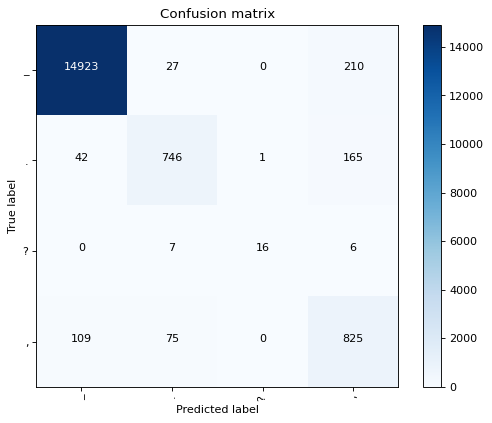

256 0.813126249151193
              precision    recall  f1-score   support

           0      0.989     0.983     0.986     15378
           1      0.868     0.778     0.820       969
           2      0.950     0.559     0.704        34
           3      0.674     0.815     0.738      1027

    accuracy                          0.961     17408
   macro avg      0.870     0.784     0.812     17408
weighted avg      0.964     0.961     0.961     17408

2020-10-29 20:01:10,249 INFO      Macro precision is: 0.870297328823309
2020-10-29 20:01:10,254 INFO      Macro recall is 0.7836444925070181
2020-10-29 20:01:10,260 INFO      Macro f-score is 0.8120247155440561
2020-10-29 20:01:10,385 INFO      Plotting confusion matrix without normalization


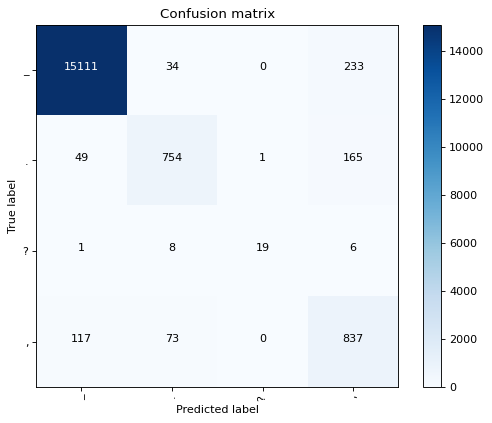

512 0.8120247155440561


In [285]:
f_scores = []
pred_num = 1
while pred_num <= 512:
    ps = combine(pred_num)
    metrics = get_eval_metrics(np.array(all_valid_target[:ps.shape[0]]), ps, config)
    print(pred_num, metrics['f_score'])
    f_scores.append(metrics['f_score'])
    pred_num *= 2

In [286]:
f_scores

[0.8091953695647445,
 0.8093462016293769,
 0.8098397145795014,
 0.8175230793250974,
 0.8170943211305286,
 0.8235746710955629,
 0.8243818231803225,
 0.8168266475832867,
 0.813126249151193,
 0.8120247155440561]

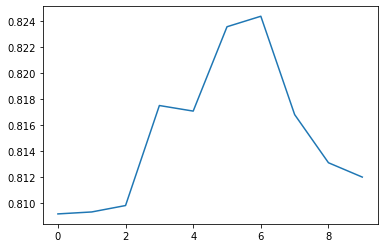

In [312]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.set_xscale('log')
plt.plot(f_scores)
plt.show()

In [314]:
with open('f_scores.pkl', 'wb') as f:
    pickle.dump(f_scores, f)

In [7]:
!pip install fairseq

  ERROR: Command errored out with exit status 1:
   command: 'D:\ProgramFiles\miniconda3\envs\neural-punctuator\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\gbenc\\AppData\\Local\\Temp\\pip-install-3vfhweek\\fairseq\\setup.py'"'"'; __file__='"'"'C:\\Users\\gbenc\\AppData\\Local\\Temp\\pip-install-3vfhweek\\fairseq\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\gbenc\AppData\Local\Temp\pip-wheel-wml8bg8q'
       cwd: C:\Users\gbenc\AppData\Local\Temp\pip-install-3vfhweek\fairseq\
  Complete output (291 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creating build\lib.win-amd64-3.8\examples
  copying examples\__init__.py -> build\lib.win-amd64-3.8\examples
  creating build\lib.win-amd64-3.8\fairseq
  copying fairseq\binarizer.py


  Using cached Cython-0.29.21-cp38-cp38-win_amd64.whl (1.7 MB)
  Running setup.py clean for fairseq
Failed to build fairseq
    Running setup.py install for fairseq: started
    Running setup.py install for fairseq: finished with status 'done'



  copying examples\noisychannel\rerank_options.py -> build\lib.win-amd64-3.8\examples\noisychannel
  copying examples\noisychannel\rerank_score_bw.py -> build\lib.win-amd64-3.8\examples\noisychannel
  copying examples\noisychannel\rerank_score_lm.py -> build\lib.win-amd64-3.8\examples\noisychannel
  copying examples\noisychannel\rerank_tune.py -> build\lib.win-amd64-3.8\examples\noisychannel
  copying examples\noisychannel\rerank_utils.py -> build\lib.win-amd64-3.8\examples\noisychannel
  copying examples\noisychannel\__init__.py -> build\lib.win-amd64-3.8\examples\noisychannel
  creating build\lib.win-amd64-3.8\examples\speech_recognition
  copying examples\speech_recognition\infer.py -> build\lib.win-amd64-3.8\examples\speech_recognition
  copying examples\speech_recognition\w2l_decoder.py -> build\lib.win-amd64-3.8\examples\speech_recognition
  copying examples\speech_recognition\__init__.py -> build\lib.win-amd64-3.8\examples\speech_recognition
  creating build\lib.win-amd64-3.8\e

  copying fairseq\tasks\audio_pretraining.py -> build\lib.win-amd64-3.8\fairseq\tasks
  copying fairseq\tasks\cross_lingual_lm.py -> build\lib.win-amd64-3.8\fairseq\tasks
  copying fairseq\tasks\denoising.py -> build\lib.win-amd64-3.8\fairseq\tasks
  copying fairseq\tasks\fairseq_task.py -> build\lib.win-amd64-3.8\fairseq\tasks
  copying fairseq\tasks\language_modeling.py -> build\lib.win-amd64-3.8\fairseq\tasks
  copying fairseq\tasks\legacy_masked_lm.py -> build\lib.win-amd64-3.8\fairseq\tasks
  copying fairseq\tasks\masked_lm.py -> build\lib.win-amd64-3.8\fairseq\tasks
  copying fairseq\tasks\multilingual_masked_lm.py -> build\lib.win-amd64-3.8\fairseq\tasks
  copying fairseq\tasks\multilingual_translation.py -> build\lib.win-amd64-3.8\fairseq\tasks
  copying fairseq\tasks\semisupervised_translation.py -> build\lib.win-amd64-3.8\fairseq\tasks
  copying fairseq\tasks\sentence_prediction.py -> build\lib.win-amd64-3.8\fairseq\tasks
  copying fairseq\tasks\sentence_ranking.py -> build\l